In [1]:
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import StepLR

# Testing with data with holes

In [9]:
# Check for GPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = torch.device('cpu')
print("Running on ", device, " cores")

# Load the data
FirstData = np.load("fullsky4catsgaiac.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# One-hot encode the labels
#encoder = OneHotEncoder(sparse_output=False)
#y = encoder.fit_transform(y.reshape(-1, 1))


from sklearn.preprocessing import LabelEncoder

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Now y is not one-hot encoded but just class indices
y = torch.tensor(y, dtype=torch.long).to(device)  # Convert to tensor for PyTorch




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(np.argmax(y, axis=1))
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer, schedular for learning rate
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)  # Moves the model to the GPU

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(y_batch.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.96:
        break

torch.save(model.state_dict(), "star_classifier_Exp1.pth") # Save the model

Running on  cpu  cores


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jcwin\AppData\Local\Temp\ipykernel_14780\402579432.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
C:\Users\jcwin\AppData\Local\Temp\ipykernel_14780\402579432.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_tes

AxisError: axis 1 is out of bounds for array of dimension 1

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("fullsky4catgaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        #x = self.softmax(self.fc5(x))
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())  # Move tensor to CPU before using np.bincount
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Check for GPU
model.to(device)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    # Use tqdm for a loading bar
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)
    
    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'\nTest Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')
    if test_accuracy > 0.96:
        break

# Save the model
torch.save(model.state_dict(), "star_classifier_Exp1.pth")


Running on  cuda


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Epoch 1/50: 100%|██████████| 1347/1347 [00:08<00:00, 166.71batch/s, Loss=2.1458]



Test Accuracy after Epoch 1: 0.6707


Epoch 2/50: 100%|██████████| 1347/1347 [00:08<00:00, 160.29batch/s, Loss=1.9360]



Test Accuracy after Epoch 2: 0.6863


Epoch 3/50: 100%|██████████| 1347/1347 [00:08<00:00, 167.72batch/s, Loss=1.8796]



Test Accuracy after Epoch 3: 0.7568


Epoch 4/50: 100%|██████████| 1347/1347 [00:07<00:00, 171.13batch/s, Loss=1.8502]



Test Accuracy after Epoch 4: 0.7651


Epoch 5/50: 100%|██████████| 1347/1347 [00:07<00:00, 169.68batch/s, Loss=1.8294]



Test Accuracy after Epoch 5: 0.7723


Epoch 6/50: 100%|██████████| 1347/1347 [00:07<00:00, 171.91batch/s, Loss=1.8137]



Test Accuracy after Epoch 6: 0.7750


Epoch 7/50: 100%|██████████| 1347/1347 [00:07<00:00, 171.57batch/s, Loss=1.7969]



Test Accuracy after Epoch 7: 0.7446


Epoch 8/50: 100%|██████████| 1347/1347 [00:07<00:00, 172.95batch/s, Loss=1.7885]



Test Accuracy after Epoch 8: 0.7836


Epoch 9/50: 100%|██████████| 1347/1347 [00:07<00:00, 168.63batch/s, Loss=1.7759]



Test Accuracy after Epoch 9: 0.7656


Epoch 10/50: 100%|██████████| 1347/1347 [00:07<00:00, 172.62batch/s, Loss=1.7700]



Test Accuracy after Epoch 10: 0.7936


Epoch 11/50: 100%|██████████| 1347/1347 [00:07<00:00, 170.61batch/s, Loss=1.7656]



Test Accuracy after Epoch 11: 0.8056


Epoch 12/50: 100%|██████████| 1347/1347 [00:07<00:00, 172.74batch/s, Loss=1.7575]



Test Accuracy after Epoch 12: 0.7772


Epoch 13/50: 100%|██████████| 1347/1347 [00:07<00:00, 177.92batch/s, Loss=1.7490]



Test Accuracy after Epoch 13: 0.7367


Epoch 14/50: 100%|██████████| 1347/1347 [00:07<00:00, 174.50batch/s, Loss=1.7451]



Test Accuracy after Epoch 14: 0.7418


Epoch 15/50: 100%|██████████| 1347/1347 [00:07<00:00, 171.72batch/s, Loss=1.7384]



Test Accuracy after Epoch 15: 0.7779


Epoch 16/50: 100%|██████████| 1347/1347 [00:07<00:00, 168.68batch/s, Loss=1.7340]



Test Accuracy after Epoch 16: 0.7990


Epoch 17/50: 100%|██████████| 1347/1347 [00:07<00:00, 168.74batch/s, Loss=1.7297]



Test Accuracy after Epoch 17: 0.7614


Epoch 18/50: 100%|██████████| 1347/1347 [00:07<00:00, 170.86batch/s, Loss=1.7234]



Test Accuracy after Epoch 18: 0.8019


Epoch 19/50: 100%|██████████| 1347/1347 [00:07<00:00, 173.51batch/s, Loss=1.7198]



Test Accuracy after Epoch 19: 0.7851


Epoch 20/50: 100%|██████████| 1347/1347 [00:07<00:00, 174.26batch/s, Loss=1.7143]



Test Accuracy after Epoch 20: 0.8028


Epoch 21/50: 100%|██████████| 1347/1347 [00:07<00:00, 169.73batch/s, Loss=1.7128]



Test Accuracy after Epoch 21: 0.7977


Epoch 22/50: 100%|██████████| 1347/1347 [00:08<00:00, 158.95batch/s, Loss=1.7085]



Test Accuracy after Epoch 22: 0.7412


Epoch 23/50: 100%|██████████| 1347/1347 [00:08<00:00, 165.71batch/s, Loss=1.7054]



Test Accuracy after Epoch 23: 0.7974


Epoch 24/50: 100%|██████████| 1347/1347 [00:08<00:00, 166.65batch/s, Loss=1.7033]



Test Accuracy after Epoch 24: 0.7800


Epoch 25/50: 100%|██████████| 1347/1347 [00:08<00:00, 164.45batch/s, Loss=1.6991]



Test Accuracy after Epoch 25: 0.7935


Epoch 26/50: 100%|██████████| 1347/1347 [00:08<00:00, 165.21batch/s, Loss=1.6939]



Test Accuracy after Epoch 26: 0.7704


Epoch 27/50: 100%|██████████| 1347/1347 [00:08<00:00, 157.93batch/s, Loss=1.6920]



Test Accuracy after Epoch 27: 0.8030


Epoch 28/50: 100%|██████████| 1347/1347 [00:08<00:00, 158.74batch/s, Loss=1.6905]



Test Accuracy after Epoch 28: 0.7807


Epoch 29/50: 100%|██████████| 1347/1347 [00:08<00:00, 157.03batch/s, Loss=1.6894]



Test Accuracy after Epoch 29: 0.8085


Epoch 30/50: 100%|██████████| 1347/1347 [00:08<00:00, 158.71batch/s, Loss=1.6875]



Test Accuracy after Epoch 30: 0.7793


Epoch 31/50: 100%|██████████| 1347/1347 [00:08<00:00, 163.44batch/s, Loss=1.6828]



Test Accuracy after Epoch 31: 0.7793


Epoch 32/50: 100%|██████████| 1347/1347 [00:08<00:00, 165.95batch/s, Loss=1.6826]



Test Accuracy after Epoch 32: 0.7815


Epoch 33/50: 100%|██████████| 1347/1347 [00:08<00:00, 166.05batch/s, Loss=1.6780]



Test Accuracy after Epoch 33: 0.8017


Epoch 34/50: 100%|██████████| 1347/1347 [00:08<00:00, 160.12batch/s, Loss=1.6730]



Test Accuracy after Epoch 34: 0.8024


Epoch 35/50: 100%|██████████| 1347/1347 [00:08<00:00, 152.51batch/s, Loss=1.6716]



Test Accuracy after Epoch 35: 0.7986


Epoch 36/50: 100%|██████████| 1347/1347 [00:08<00:00, 156.11batch/s, Loss=1.6715]



Test Accuracy after Epoch 36: 0.8084


Epoch 37/50: 100%|██████████| 1347/1347 [00:07<00:00, 169.00batch/s, Loss=1.6677]



Test Accuracy after Epoch 37: 0.7978


Epoch 38/50: 100%|██████████| 1347/1347 [00:07<00:00, 173.55batch/s, Loss=1.6657]



Test Accuracy after Epoch 38: 0.7857


Epoch 39/50: 100%|██████████| 1347/1347 [00:07<00:00, 168.43batch/s, Loss=1.6661]



Test Accuracy after Epoch 39: 0.8162


Epoch 40/50: 100%|██████████| 1347/1347 [00:08<00:00, 167.40batch/s, Loss=1.6599]



Test Accuracy after Epoch 40: 0.8096


Epoch 41/50: 100%|██████████| 1347/1347 [00:08<00:00, 168.18batch/s, Loss=1.6606]



Test Accuracy after Epoch 41: 0.8034


Epoch 42/50: 100%|██████████| 1347/1347 [00:07<00:00, 168.62batch/s, Loss=1.6603]



Test Accuracy after Epoch 42: 0.7988


Epoch 43/50: 100%|██████████| 1347/1347 [00:07<00:00, 169.99batch/s, Loss=1.6561]



Test Accuracy after Epoch 43: 0.7941


Epoch 44/50: 100%|██████████| 1347/1347 [00:07<00:00, 170.63batch/s, Loss=1.6586]



Test Accuracy after Epoch 44: 0.7999


Epoch 45/50: 100%|██████████| 1347/1347 [00:08<00:00, 166.69batch/s, Loss=1.6540]



Test Accuracy after Epoch 45: 0.7782


Epoch 46/50: 100%|██████████| 1347/1347 [00:08<00:00, 162.58batch/s, Loss=1.6544]



Test Accuracy after Epoch 46: 0.8141


Epoch 47/50: 100%|██████████| 1347/1347 [00:08<00:00, 166.39batch/s, Loss=1.6554]



Test Accuracy after Epoch 47: 0.7709


Epoch 48/50: 100%|██████████| 1347/1347 [00:08<00:00, 165.52batch/s, Loss=1.6511]



Test Accuracy after Epoch 48: 0.8057


Epoch 49/50: 100%|██████████| 1347/1347 [00:08<00:00, 161.37batch/s, Loss=1.6531]



Test Accuracy after Epoch 49: 0.7735


Epoch 50/50: 100%|██████████| 1347/1347 [00:09<00:00, 148.59batch/s, Loss=1.6504]



Test Accuracy after Epoch 50: 0.8116


 ### Analysis

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Classification Report:
               precision    recall  f1-score   support

         AB*       0.01      0.14      0.01       221
         Ae*       0.00      0.00      0.00        11
         BS*       0.29      0.91      0.44       676
         Be*       0.40      0.90      0.55       315
          C*       0.00      0.00      0.00      2602
         Ce*       0.00      0.00      0.00       189
         HB*       0.51      0.68      0.58      5001
          HH       0.00      0.00      0.00         3
         HS*       0.58      0.95      0.72       760
         LP*       0.97      0.87      0.92     49420
         MS*       0.00      0.00      0.00        12
         Mi*       0.59      0.88      0.71      5212
         OH*       0.00      0.00      0.00        22
         Or*       0.00      0.00      0.00       113
          PN       0.00      0.00      0.00        83
         Psr       0.00      0.00      0.00        15
         RG*       0.73      0.68      0.70     10762
   

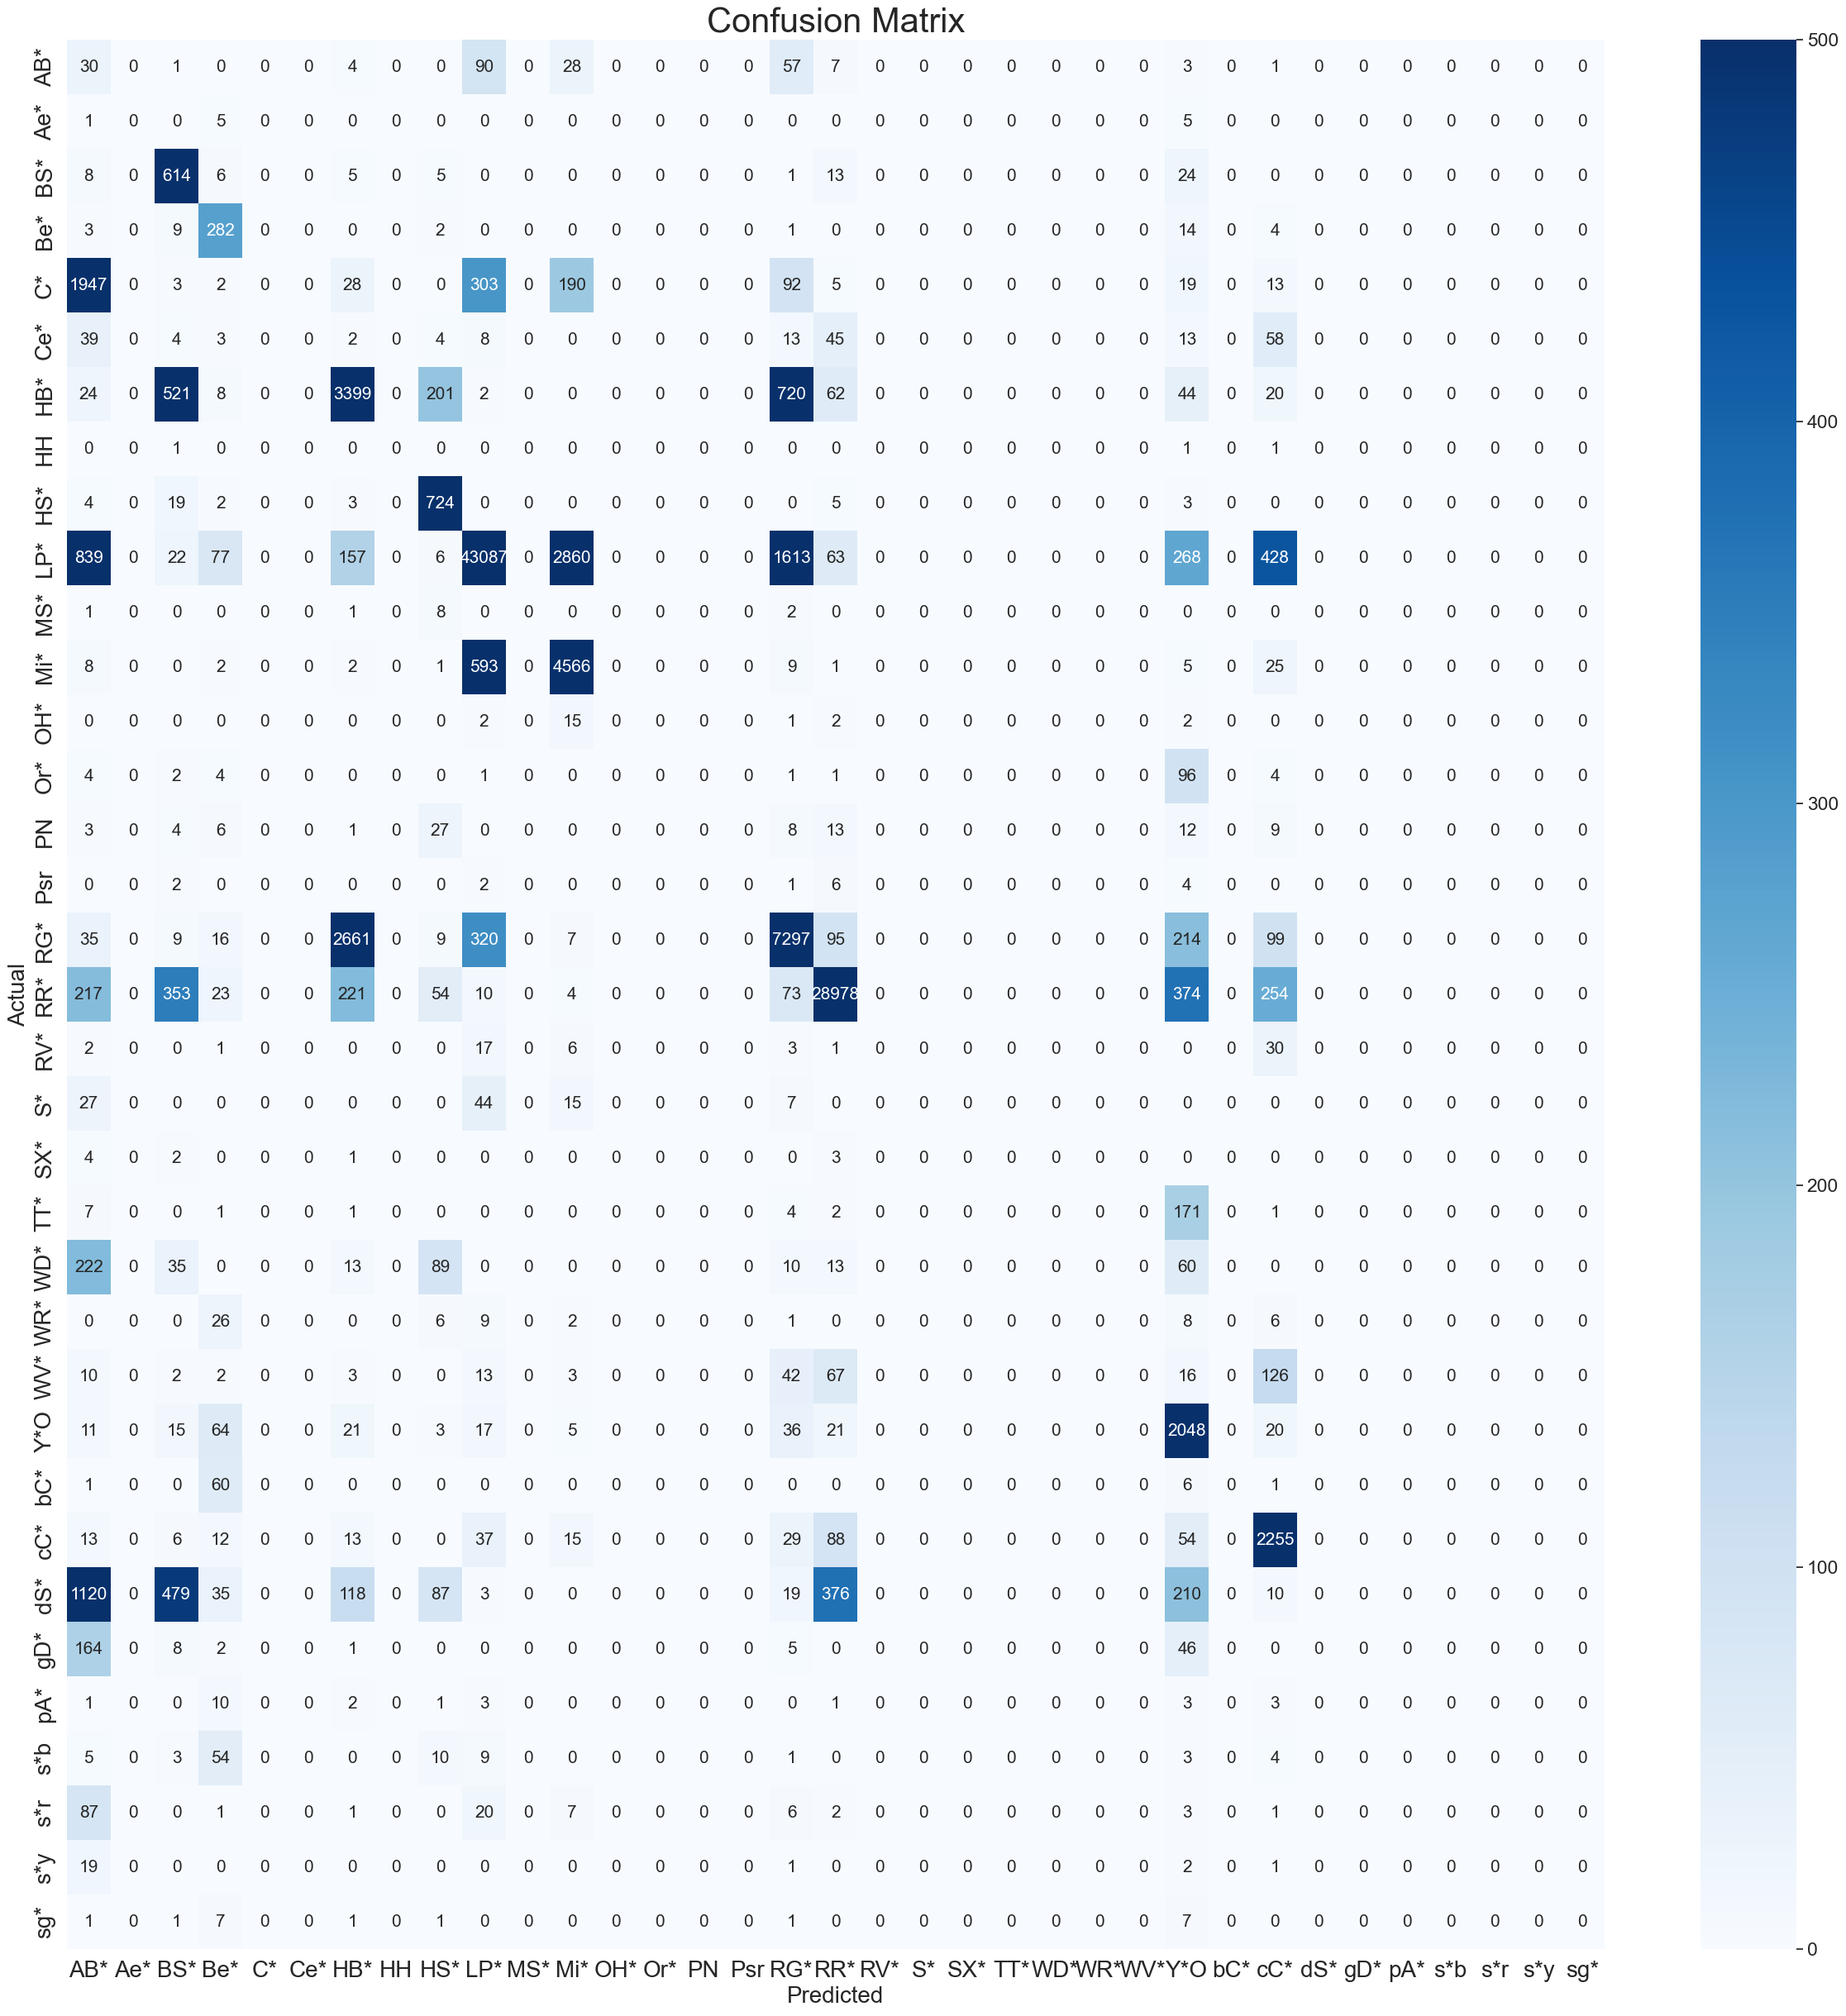

In [26]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
